# Data Preprocessing

In [467]:
# Data handling
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras_tuner as kt

# Machine learning metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [468]:
# Data pipeline
def process_data(df):
    """
    Prepare data that can be readily consumed by ML/DL algorithms.
    - remove elevation outliers for Spruce/Fir and Lodgepole Pine
    - separate features from class variables
    - split into training and testing dataset
    - scale numerical data
    
    param: a dataframe of input data
    output: X_train_normalized, X_test_normalized, y_train, y_test
    """
    # Remove elevation outliers for Spruce/Fir
    df_drop_outliers = df.drop(df[(df['class'] == 1) & (df['Elevation'] < 2730) | (df['Elevation'] > 3538)].index)
    # Remove elevation outliers for Lodgepole Pine
    df_drop_outliers = df.drop(df[(df['class'] == 2) & (df['Elevation'] < 2422) | (df['Elevation'] > 3414.0)].index)

    # Split data into features and labels
    df_features = df_drop_outliers.iloc[:, :-1]
    # We subract 1 from every class value to include 0 as a label for the softmax
    df_labels = df_drop_outliers['class'] 

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.2, stratify=df_labels)

    # Normalise data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

In [469]:
# ML pipeline
def build_model(features):
    """
    Build the model architecture (and compile it).
    input: number of features
    output: Keras model object.
    """    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(features.shape[1])))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.025))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.01))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print("Summary report of Keras classifier:")
    model.summary()

    return model

In [470]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

In [471]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'../Forest-Cover-Classification/')

The main function below drives the entire code. It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.

In [472]:
def main():
    # Read csv
    filename = 'cover_data.csv'
    print(f"Reading {filename}")
    df = pd.read_csv(filename)

    # Process data
    X_train, X_test, y_train, y_test = process_data(df)

    # Build Deep Learning Model
    model = build_model(X_train)

    # Set params
    num_epochs = 150
    batch_size = 128
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10)
    
    # Build model
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs, 
                        batch_size=batch_size, 
                        callbacks=[es], 
                        validation_split=0.1, 
                        verbose=1)

    # Visualise performance 
    plot_history(history, 'acc')
    plot_history(history, 'loss')

    # Evaluate model
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {score[0]}")
    print(f"Test accuracy: {score[1]}")

    y_pred = model.predict(X_test)

    # Convert predictions to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)    

Reading cover_data.csv
Summary report of Keras classifier:
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 256)               14080     
                                                                 
 dropout_83 (Dropout)        (None, 256)               0         
                                                                 
 dense_109 (Dense)           (None, 128)               32896     
                                                                 
 dropout_84 (Dropout)        (None, 128)               0         
                                                                 
 dense_110 (Dense)           (None, 64)                8256      
                                                                 
 dropout_85 (Dropout)        (None, 64)                0         
                                                            

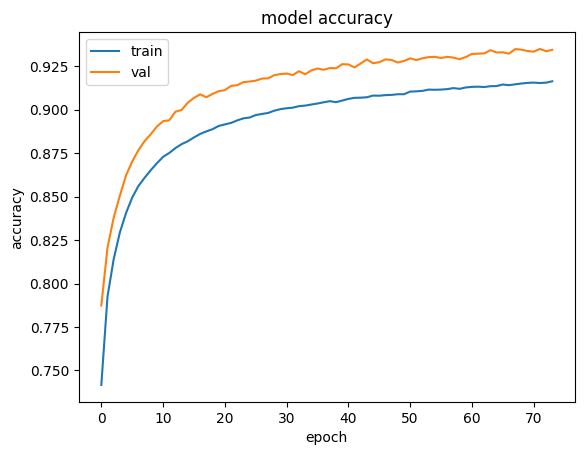

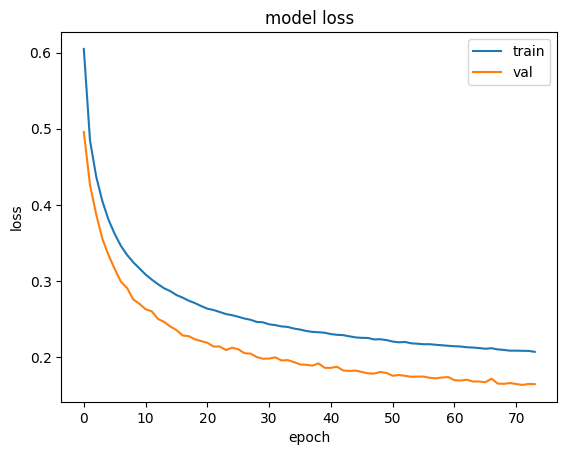

Test loss: 0.16414020955562592
Test accuracy: 0.9348704814910889
3572/3572 [==============================] - 6s 2ms/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.95      0.92      0.93     41519
   Lodgepole Pine       0.94      0.96      0.95     56493
   Ponderosa Pine       0.91      0.96      0.93      7151
Cottonwood/Willow       0.85      0.78      0.81       549
            Aspen       0.81      0.82      0.81      1899
      Douglas-fir       0.90      0.86      0.88      3473
        Krummholz       0.93      0.91      0.92      3196

         accuracy                           0.93    114280
        macro avg       0.90      0.89      0.89    114280
     weighted avg       0.93      0.93      0.93    114280



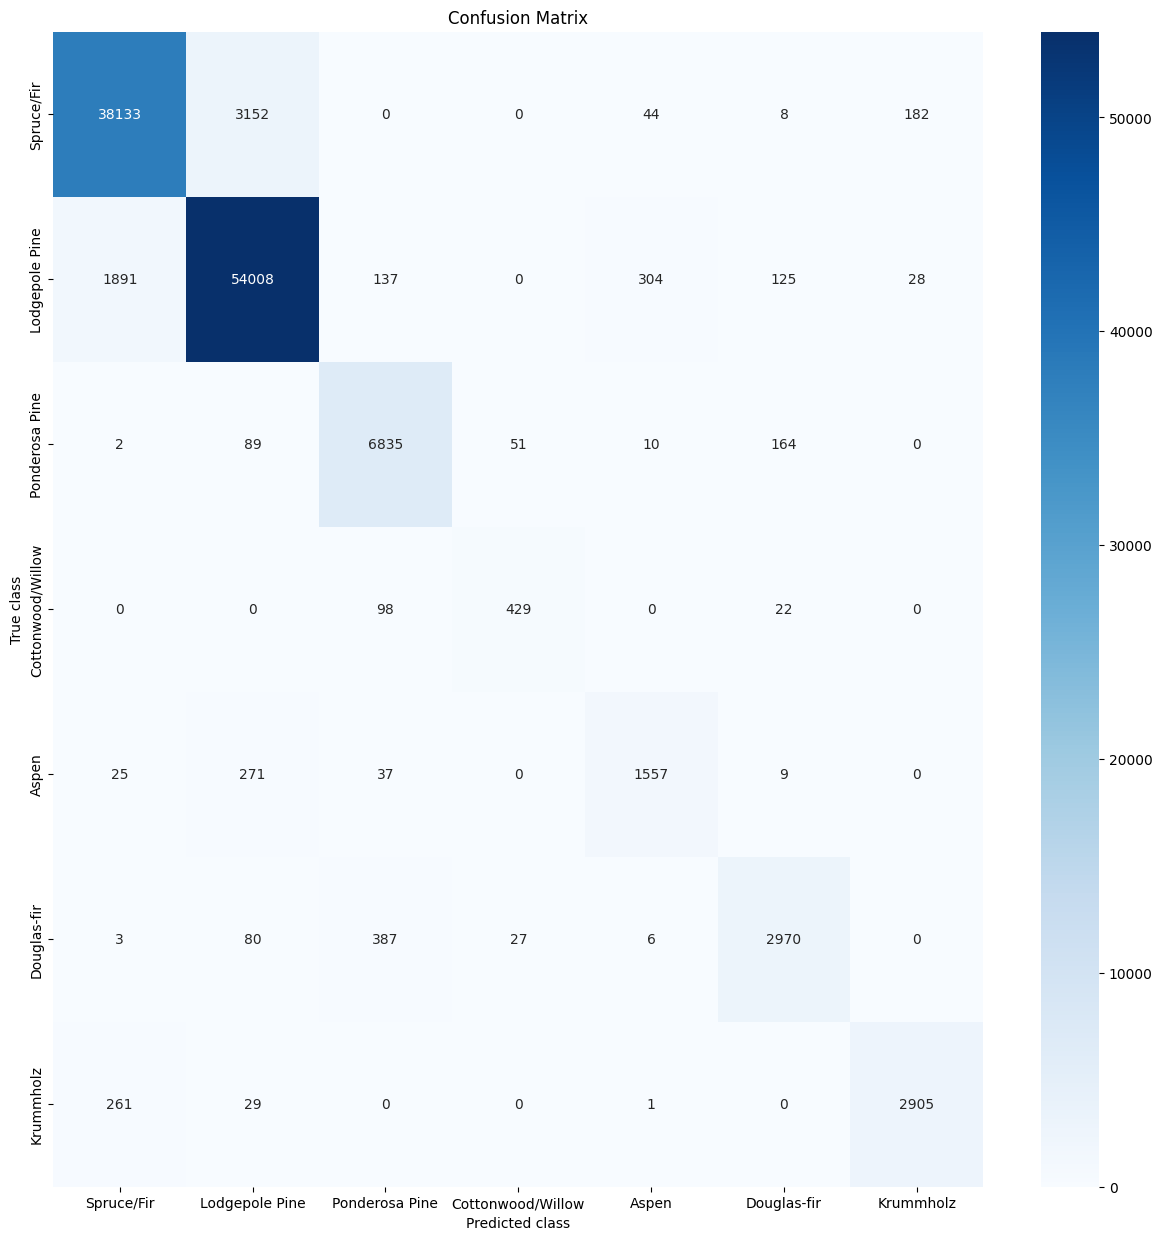

In [473]:
if __name__ == '__main__':
    main()

# Evaluation

The model achieved 91.64 % accuracy on the training set and 93.45 % accuracy on the validation set.  On the testing set, the model achieved 93.48 % accuracy. The accuracy achieved on the validation and training set is higher than the accuracy achieved on the training data. Thus, the model has not overfitted with the training set. 

The accuracy plots show the validation accuracy/loss was higher than the training accuracy/loss throughout the span of epochs. This is due implementing dropout layers, disabling a random number of neurons during training, but enabling them back when performing the model on the validation set.

The F1 scores for Spruce/Fir, Lodgepole Pine, Ponderosa Pine and Douglas Fir were relatively great. Ponderosa Pine had a higher F1 score than Spruce/Fir despite Spruce/Fir being much heavily sampled. However, the F1 scores for Cottonwood/Willow and Aspen were significantly lower compared to the rest of the cover types. This is likely due to the sample sizes for both Cottonwood/Willow and Aspen being signicantly smaller than the rest of the cover types. Both cover types make up ~2 % of the dataset.

# Future Work

The main issue with the model is that it uses a imbalanced dataset. To improve this, random oversampling can be used on Aspen and Cottonwood to increase its sample size. In addition, samples for the rest of the classes can be removed by removing its outliers accross all the features in the dataset. This will not only make the dataset cleaner, but will make the dataset less imbalanced. Also, ‘Soil_Type7’, ‘Soil_Type8’, ‘Soil_Type14’, ‘Soil_Type15’, ‘Soil_Type25’, ‘Soil_Type36’, ‘Soil_Type37’ - these soil types have very few samples compared to the others, removing these samples could further clean the model.

Furthermore, further hyper-params could be added and tuned; the validation and test accuracy was higher than the training data suggesting additionally params can be allowed. Another hidden layer with 512 neurons would be benifitial. Also, tuning was applied to the choice of activation functions and choice of optimiser.